## Transfer Learning with VGG16

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras import layers

Use eager tensor to be able iterate on Batch Datasets

In [3]:
tf.compat.v1.enable_eager_execution()

Set data folder

In [41]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

data_folder = pathlib.Path('../../facial_expression_recognition/images')

Test file is uploaded as csv, read it and display columns. Unfortunately, there is no label information for the test data.

In [11]:
import pandas as pd

# Load the Test CSV file
data = pd.read_csv('../../test.csv')
data.head(15)


,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
5,235 233 223 109 34 37 34 31 28 38 56 69 106 13...
6,71 70 104 147 166 170 195 145 156 154 146 129 ...
7,176 177 170 168 173 171 167 169 166 139 98 107...
8,255 255 255 255 255 255 255 255 255 255 255 25...
9,126 126 123 119 116 113 112 111 110 111 93 72 ...


Test samples have no labels.

In [4]:


train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(48, 48),
    label_mode='categorical',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(48, 48),
    label_mode='categorical',
    batch_size=32)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [6]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 48, 48, 3)
labels batch shape: (32, 7)


Look at distribution of classes.<br>
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [8]:
label_counts = {}

for _, label in train_dataset:
    original_labels = tf.argmax(label, axis=-1).numpy()
    for lbl in original_labels:
        if lbl in label_counts:
            label_counts[lbl] += 1
        else:
            label_counts[lbl] = 1

for label_value, count in label_counts.items():
    print(f"Label {label_value}: Count {count}")


Label 0: Count 3993
Label 3: Count 7164
Label 5: Count 4938
Label 4: Count 4982
Label 2: Count 4103
Label 6: Count 3205
Label 1: Count 436


Disgust is less than other labels, it creates imbalance.

Text(0.5, 1.0, 'Distribution of Classes')

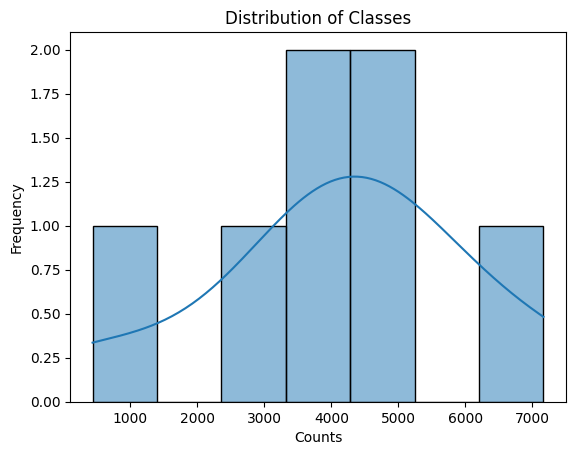

In [12]:
import seaborn as sns

sns.histplot(label_counts, bins=7, kde=True)  # 'kde' adds a kernel density estimate curve
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')

In order to mitigate imbalance utilize ImageDataGenerator class. It is a utility class provided by Keras, a popular deep learning framework, to perform real-time data augmentation and preprocessing for image data. It's particularly useful when training neural networks, especially Convolutional Neural Networks (CNNs), on image datasets. Data augmentation is a technique that helps to artificially increase the size of your training dataset by applying various transformations to the original images. This can lead to improved model generalization and better performance.

In [73]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 32
pic_size = 48

datagen_train = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


datagen_validation = ImageDataGenerator(rescale=1./255)


train_generator = datagen_train.flow_from_directory(data_folder / "train",
                                                    target_size=(pic_size, pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = datagen_validation.flow_from_directory(data_folder / "validation",
                                                    target_size=(pic_size, pic_size),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Freeze all layers of VGG16 - Apply Transfer Learning. VGG16 refers to the VGG model, also called VGGNet. It is a convolution neural network (CNN) model supporting 16 layers. K. Simonyan and A. Zisserman from Oxford University proposed this model and published it in a paper called Very Deep Convolutional Networks for Large-Scale Image Recognition.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3))

conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Apply two Dense layers on the top on VGG16 model.

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_3 = keras.Model(inputs, outputs)

Train dataset with learning rate 0.0001, optimizer is Nadam. Nadam (Nesterov-accelerated Adaptive Moment Estimation) is an optimization algorithm commonly used for training artificial neural networks, particularly in the context of deep learning. It is a variant of the popular Adam (Adaptive Moment Estimation) optimizer and incorporates Nesterov's accelerated gradient (NAG) method.


In [76]:
from keras.callbacks import ModelCheckpoint

epochs = 40

opt = keras.optimizers.Nadam(learning_rate=1e-4)

model_3.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/transfer.keras",
        save_best_only=True,
        monitor="val_loss")
]


history = model_3.fit(train_generator,
                    validation_data = valid_generator,
                    epochs=40, 
                    verbose=1,
                    callbacks=callbacks)


Epoch 1/40
901/901 [==============================] - 18s 19ms/step - loss: 1.8146 - accuracy: 0.2389 - val_loss: 1.7928 - val_accuracy: 0.2608
Epoch 2/40
901/901 [==============================] - 17s 19ms/step - loss: 1.8119 - accuracy: 0.2394 - val_loss: 1.7922 - val_accuracy: 0.2617
Epoch 3/40
901/901 [==============================] - 17s 19ms/step - loss: 1.8131 - accuracy: 0.2398 - val_loss: 1.7897 - val_accuracy: 0.2600
Epoch 4/40
901/901 [==============================] - 17s 18ms/step - loss: 1.8123 - accuracy: 0.2433 - val_loss: 1.7890 - val_accuracy: 0.2615
Epoch 5/40
901/901 [==============================] - 17s 19ms/step - loss: 1.8113 - accuracy: 0.2399 - val_loss: 1.7878 - val_accuracy: 0.2646
Epoch 6/40
901/901 [==============================] - 17s 18ms/step - loss: 1.8111 - accuracy: 0.2409 - val_loss: 1.7876 - val_accuracy: 0.2613
Epoch 7/40
901/901 [==============================] - 17s 19ms/step - loss: 1.8108 - accuracy: 0.2404 - val_loss: 1.7904 - val_accuracy:

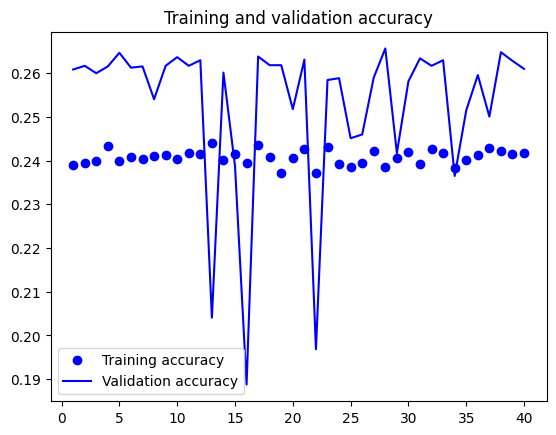

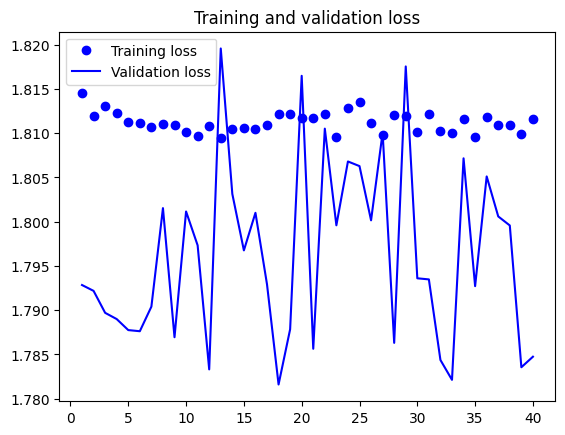

In [77]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

After approx. 10 epochs, there is no improvement on validadtion accuracy. Even training accuracy is lower than the original model. Therefore, we decided to apply fine tuning by unfreezing last 4 layers.

Unfreeze last 4 layers of VGG16

In [78]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3))

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [86]:
inputs = keras.Input(shape=(48, 48, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_4_layers = keras.Model(inputs, outputs)

In [87]:
opt = keras.optimizers.Nadam(learning_rate=1e-5)
model_4_layers.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/unfreeze_last_4.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_4_layers.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40


901/901 [==============================] - 20s 21ms/step - loss: 1.9369 - accuracy: 0.2482 - val_loss: 1.9248 - val_accuracy: 0.2584
Epoch 2/40
901/901 [==============================] - 19s 21ms/step - loss: 1.9157 - accuracy: 0.2488 - val_loss: 1.9052 - val_accuracy: 0.2586
Epoch 3/40
901/901 [==============================] - 18s 20ms/step - loss: 1.8978 - accuracy: 0.2487 - val_loss: 1.8870 - val_accuracy: 0.2586
Epoch 4/40
901/901 [==============================] - 18s 20ms/step - loss: 1.8800 - accuracy: 0.2487 - val_loss: 1.8702 - val_accuracy: 0.2586
Epoch 5/40
901/901 [==============================] - 20s 22ms/step - loss: 1.8644 - accuracy: 0.2488 - val_loss: 1.8554 - val_accuracy: 0.2586
Epoch 6/40
901/901 [==============================] - 20s 22ms/step - loss: 1.8514 - accuracy: 0.2488 - val_loss: 1.8435 - val_accuracy: 0.2587
Epoch 7/40
901/901 [==============================] - 20s 23ms/step - loss: 1.8410 - accuracy: 0.2488 - val_loss: 1.8341 - val_accuracy: 0.2586
Epo

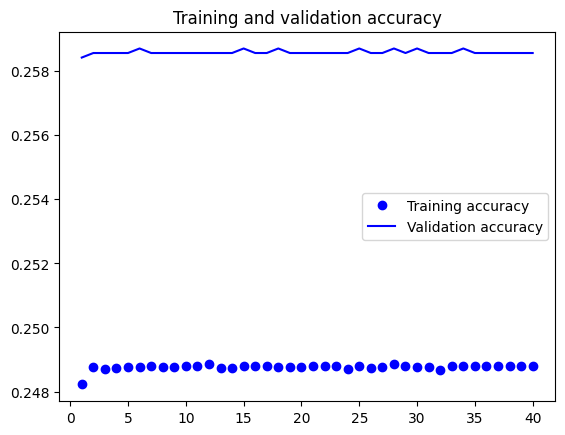

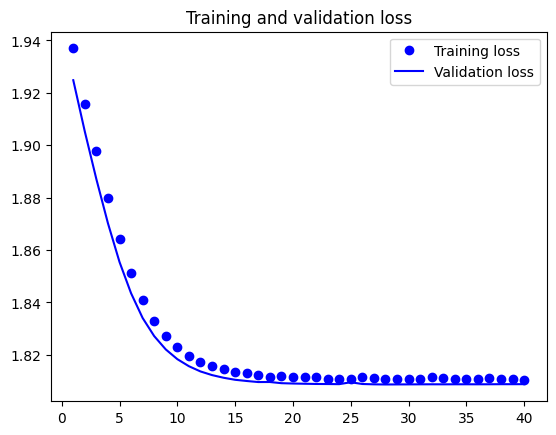

In [88]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


# Another experiment with balancing the dataset 

We want to oversample the underrepresented samples in imbalanced dataset, which is Disgust = 1

In [39]:
from sklearn.utils.class_weight import compute_class_weight

In [72]:
y = np.concatenate([tf.argmax(y, axis=1) for x, y in train_dataset], axis=0)

In [82]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(enumerate(class_weights))
weight_dict

{0: 1.031125898894494,
 1: 9.443315858453474,
 2: 1.0034817729187702,
 3: 0.5747188322565207,
 4: 0.8264322991340254,
 5: 0.8337962159347335,
 6: 1.2846445286382884}

In [77]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3))

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [83]:
inputs = keras.Input(shape=(48, 48, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(7, activation="softmax")(x)
model_weight = keras.Model(inputs, outputs)

In [84]:
model_weight.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/class_weight.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_weight.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    class_weight = weight_dict,
    callbacks=callbacks)

Epoch 1/50
901/901 [==============================] - 18s 19ms/step - loss: 1.9464 - accuracy: 0.0911 - val_loss: 1.9455 - val_accuracy: 0.1359
Epoch 2/50
901/901 [==============================] - 17s 18ms/step - loss: 1.9463 - accuracy: 0.1221 - val_loss: 1.9450 - val_accuracy: 0.1441
Epoch 3/50
901/901 [==============================] - 17s 19ms/step - loss: 1.9464 - accuracy: 0.1326 - val_loss: 1.9446 - val_accuracy: 0.1441
Epoch 4/50
901/901 [==============================] - 17s 19ms/step - loss: 1.9464 - accuracy: 0.1193 - val_loss: 1.9444 - val_accuracy: 0.2583
Epoch 5/50
901/901 [==============================] - 17s 18ms/step - loss: 1.9464 - accuracy: 0.1366 - val_loss: 1.9449 - val_accuracy: 0.1441
Epoch 6/50
901/901 [==============================] - 17s 19ms/step - loss: 1.9464 - accuracy: 0.1269 - val_loss: 1.9441 - val_accuracy: 0.1441
Epoch 7/50
901/901 [==============================] - 18s 20ms/step - loss: 1.9464 - accuracy: 0.1352 - val_loss: 1.9428 - val_accuracy:

In [ ]:
Both accuracies are pretty low.